## Reto
Endesa como comercializadora tiene que hacer la previsión de consumo eléctrico para sus
clientes.

Dentro de todos los clientes, vamos a hacer foco en el sector de las pymes, en donde
necesitamos saber cuánto van a consumir 2.770 de nuestros clientes de manera agregada.

Para cada uno de los puntos de suministro se proporcionan valores de consumo diario en todo
el periodo, por lo que no es necesaria interpolación de los mismos, si bien pueden contener
datos anómalos. Adicionalmente se proporcionan características de cada uno de los puntos.

Las series de consumo eléctrico tienen estacionalidad, y una de las principales variables que
rigen su comportamiento es la temperatura. Se proporcionan las temperaturas máximas y
mínima que se han registrado en los diferentes observatorios meteorológicos durante el periodo
de estudio

El objetivo es estimar el consumo diario agregado de todos nuestros clientes para el día siguiente
(d+1), teniendo en cuenta que cada día d se dispone de:
* Los consumos del día d-2 por cliente
* Las temperaturas hasta el día d+1


In [1]:
####################################################
# Import las librerias necesarias
####################################################
import pandas as pd
import numpy as np


# Plots 
import matplotlib.pyplot as plt
from matplotlib import style

# Default style 
style.use('default')

import seaborn as sb
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

#Sklearn
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

# Modelado
import xgboost as xgb
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.utils import np_utils
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping

#Forecasting
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster



In [22]:
####################################################
# Carga de consumo y visualizacion
####################################################
df_consumo = pd.read_csv(r'Consumption.csv', sep = ';')
df_consumo.head()
print(df_consumo.shape)
print("="*90)
print(df_consumo.info())
print("="*90)
df_consumo.head()

(2022100, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2022100 entries, 0 to 2022099
Data columns (total 3 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   id       int64 
 1   Fecha    int64 
 2   consumo  object
dtypes: int64(2), object(1)
memory usage: 46.3+ MB
None


,id,Fecha,consumo
0,57,20181103,"502,32"
1,57,20181024,"447,44"
2,57,20181025,"525,28"
3,57,20181026,"493,92"
4,57,20181027,"490,56"


In [23]:
####################################################
# Carga de portfolio y visualizacion
####################################################
df_portfolio = pd.read_csv(r'Portfolio.csv', sep=';')
print(df_portfolio.shape)
print("="*90)
print(df_portfolio.info())
print("="*90)
df_portfolio.head()
print("="*90)


(4000, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 4000 non-null   int64  
 1   CNAE               4000 non-null   int64  
 2   Tension            4000 non-null   int64  
 3   P1                 3998 non-null   float64
 4   P2                 3998 non-null   float64
 5   P3                 3998 non-null   float64
 6   P4                 3998 non-null   float64
 7   P5                 3998 non-null   float64
 8   P6                 3998 non-null   float64
 9   Desc_Municipio_ID  4000 non-null   int64  
 10  Observatorio       4000 non-null   int64  
dtypes: float64(6), int64(5)
memory usage: 343.9 KB
None


,id,CNAE,Tension,P1,P2,P3,P4,P5,P6,Desc_Municipio_ID,Observatorio
0,57,1089,25000,400000.0,400000.0,400000.0,0.0,0.0,0.0,8019,8181
1,71,3600,25000,301000.0,430000.0,301000.0,0.0,0.0,0.0,8307,8181
2,96,2361,25000,160000.0,160000.0,160000.0,0.0,0.0,0.0,43145,8175
3,101,8430,25000,100000.0,364000.0,100000.0,0.0,0.0,0.0,8019,8181
4,102,8411,25000,198100.0,224000.0,198100.0,0.0,0.0,0.0,8019,8181


In [24]:
####################################################
# Carga de temperaturas y visualizacion
####################################################
df_temperaturas = pd.read_csv(r'Temperaturas.csv', sep=';')
print(df_temperaturas.shape)
print("="*90)
print(df_temperaturas.info())
print("="*90)
df_temperaturas.head()

(37950, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37950 entries, 0 to 37949
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID_OBS  37950 non-null  int64 
 1   FECHA   37950 non-null  object
 2   TRMax   37950 non-null  object
 3   TRMin   37950 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB
None


,ID_OBS,FECHA,TRMax,TRMin
0,8221,01/01/2019,"15,19","-3,5"
1,8231,01/01/2019,"16,89","-3,09"
2,8235,01/01/2019,"14,6","-5,3"
3,8261,01/01/2019,16,"0,8"
4,8279,01/01/2019,"16,89","-2,2"


Para un tratamiento más simplificado de los datos, agruparemos todos lso datos, hemos de tener especial cuidado con las fechsa y los observatorios. 

In [54]:
df_info_cliente = df_consumo.merge(df_portfolio, on = 'id', how = 'left')
df_info_cliente.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2022100 entries, 0 to 2022099
Data columns (total 13 columns):
 #   Column             Dtype  
---  ------             -----  
 0   id                 int64  
 1   Fecha              int64  
 2   consumo            object 
 3   CNAE               int64  
 4   Tension            int64  
 5   P1                 float64
 6   P2                 float64
 7   P3                 float64
 8   P4                 float64
 9   P5                 float64
 10  P6                 float64
 11  Desc_Municipio_ID  int64  
 12  Observatorio       int64  
dtypes: float64(6), int64(6), object(1)
memory usage: 216.0+ MB


In [61]:
####################################################
# Tratamiento de la fecha en la tabla de temperatura para que tenga el mismo formato que en la de consumos
####################################################
import datetime
df_temperaturas['Fecha'] = df_temperaturas['FECHA'].apply(lambda x: datetime.datetime.strptime(x, "%d/%m/%Y").strftime("%Y%m%d"))
# Cambio a int para poder hacer el merge
df_temperaturas['Fecha'] = df_temperaturas['Fecha'].astype(str).astype(int)
df_temperaturas.head()


# Podria hacer un drop del campo original para que la tabla pese menos. 

,ID_OBS,FECHA,TRMax,TRMin,Fecha
0,8221,01/01/2019,"15,19","-3,5",20190101
1,8231,01/01/2019,"16,89","-3,09",20190101
2,8235,01/01/2019,"14,6","-5,3",20190101
3,8261,01/01/2019,16,"0,8",20190101
4,8279,01/01/2019,"16,89","-2,2",20190101


In [152]:
####################################################
# Join de los datos 
####################################################
df = df_info_cliente.merge(df_temperaturas, 
                            left_on = ['Observatorio', 'Fecha'],
                            right_on = ['ID_OBS','Fecha'],
                            how='inner')
# Para poder tratar el consumo, lo pasaremos a float. Primero hemos de cambiar la coma por punto
df['consumo'] = df['consumo'].astype(str).str.replace(',','.').astype('float')
df['TRMax'] = df['TRMax'].astype(str).str.replace(',','.').astype('float')
df['TRMin'] = df['TRMin'].astype(str).str.replace(',','.').astype('float')
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2022100 entries, 0 to 2022099
Data columns (total 17 columns):
 #   Column             Dtype  
---  ------             -----  
 0   id                 int64  
 1   Fecha              int64  
 2   consumo            float64
 3   CNAE               int64  
 4   Tension            int64  
 5   P1                 float64
 6   P2                 float64
 7   P3                 float64
 8   P4                 float64
 9   P5                 float64
 10  P6                 float64
 11  Desc_Municipio_ID  int64  
 12  Observatorio       int64  
 13  ID_OBS             int64  
 14  FECHA              object 
 15  TRMax              float64
 16  TRMin              float64
dtypes: float64(9), int64(7), object(1)
memory usage: 277.7+ MB


In [133]:
value = '1,2'.replace(',','.')
value

'1.2'

Como podemos observar, ya tenemos un dataset completo con el que trabajar. En caso de tener una cantidad mucho mayor de datos, se podrían tratar con PySpark para después tomar una muestra menor de ellos y realizar los modelos.\
Una vez los modelos estuvieran realizados y viéramos su funcionalidad, se podría hacer la puesta en producción

In [90]:
####################################################
# Podemos ver que tenemos algunos na en la potencia, así que haremos un drop de estos para que no molesten en el modelo. 
####################################################
print(df.isna().sum())
print('--------')


id                   0
Fecha                0
consumo              0
CNAE                 0
Tension              0
P1                   0
P2                   0
P3                   0
P4                   0
P5                   0
P6                   0
Desc_Municipio_ID    0
Observatorio         0
ID_OBS               0
FECHA                0
TRMax                0
TRMin                0
dtype: int64
--------


In [153]:
####################################################
# Podemos ver que tenemos algunos na en la potencia, así que haremos un drop de estos para que no molesten en el modelo. 
####################################################
df = df.dropna()
df = df.sort_values(by='Fecha')
df.head()

,id,Fecha,consumo,CNAE,Tension,P1,P2,P3,P4,P5,P6,Desc_Municipio_ID,Observatorio,ID_OBS,FECHA,TRMax,TRMin
821079,26201,20170701,246.40,9491,20000,157000.0,157000.0,157000.0,0.0,0.0,0.0,41091,8391,8391,01/07/2017,33.50,15.5
542151,17007,20170701,332.64,4765,20000,110000.0,110000.0,110000.0,0.0,0.0,0.0,14021,8410,8410,01/07/2017,34.29,16.6
542152,17009,20170701,350.00,5610,20000,122000.0,135000.0,89000.0,0.0,0.0,0.0,14021,8410,8410,01/07/2017,34.29,16.6
542153,17013,20170701,62.72,3811,15000,39000.0,55000.0,31000.0,0.0,0.0,0.0,14021,8410,8410,01/07/2017,34.29,16.6
542154,17016,20170701,390.32,4771,20000,118000.0,212000.0,118000.0,0.0,0.0,0.0,14021,8410,8410,01/07/2017,34.29,16.6


In [168]:
####################################################
# Para un primer modelo, la unica información que queremos será la temperatura, la fecha, el consumo y la poetncia. Nos quedaremos con esos datos para hacer el dataset del modelo
####################################################
df_modelo = df[['Fecha', 'consumo', 'P1','P2', 'TRMax', 'TRMin']]
df_modelo['Fecha'] = pd.to_datetime(df_modelo['Fecha'].astype(str), format='%Y%m%d')
df_modelo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2020640 entries, 821079 to 61138
Data columns (total 6 columns):
 #   Column   Dtype         
---  ------   -----         
 0   Fecha    datetime64[ns]
 1   consumo  float64       
 2   P1       float64       
 3   P2       float64       
 4   TRMax    float64       
 5   TRMin    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 107.9 MB


C:\Users\adana\AppData\Local\Temp\ipykernel_3288\2392131614.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [174]:
####################################################
# A partir de la fecha, crearemos el modelo de train y test
####################################################
df['Fecha'].unique()
# Veo que el primer dato es 20170701 y el último es 20190630. Dividiré en un train, un test para evitar sobreajuste de 2 meses y otro test para validar.
# En las condiciones usare df[fecha] porque ahi fecha sigue siendo stirng.
df_train = df_modelo[(201701<=df['Fecha']) & (df['Fecha']<=20181231)] # todos los datos
df_validacion = df_modelo[(20181231<=df['Fecha']) & (df['Fecha']<=20190601)] # 6 meses 
df_test = df_modelo[20190601<=df['Fecha']] # un mes
print(f"Fechas train      : {df_train.Fecha.min()} --- {df_train.Fecha.max()}")
print(f"Fechas validacion : {df_validacion.Fecha.min()} --- {df_validacion.Fecha.max()}")
print(f"Fechas test       : {df_test.Fecha.min()} --- {df_test.Fecha.max()}")


Fechas train      : 2017-07-01 00:00:00 --- 2018-12-31 00:00:00
Fechas validacion : 2018-12-31 00:00:00 --- 2019-06-01 00:00:00
Fechas test       : 2019-06-01 00:00:00 --- 2019-06-30 00:00:00


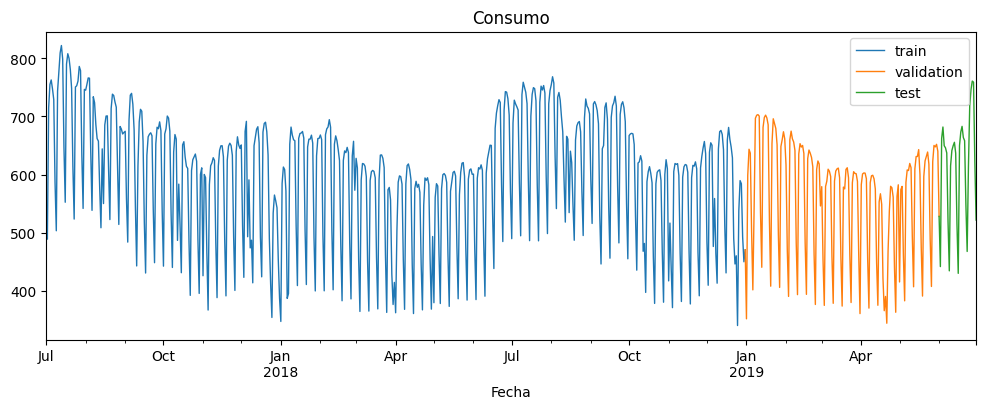

In [178]:
df_agrupado_train = df_train.groupby('Fecha').mean()
df_agrupado_validacion = df_validacion.groupby('Fecha').mean()
df_agrupado_test = df_test.groupby('Fecha').mean()
####################################################
# Veamos ahora de forma gráfica los datos
####################################################
fig, ax = plt.subplots(figsize=(12, 4))
df_agrupado_train.consumo.plot(ax=ax, label='train', linewidth=1)
df_agrupado_validacion.consumo.plot(ax=ax, label='validation', linewidth=1)
df_agrupado_test.consumo.plot(ax=ax, label='test', linewidth=1)
ax.set_title('Consumo')
ax.legend();


Podemos apreciar estacionalidad y como el consumo empieza a aumentar de cada al test, que es verano.

In [204]:
####################################################
# Como el anterior approach no me convence, probaré con uno nuevo. En este caso deberia haberme quedado con todas las variabes, pero no lo he hecho .
####################################################
df_agrupado = df_modelo.groupby('Fecha').mean()
df_train =  df_agrupado.loc[:'2028-12-31',:]
df_validacion =  df_agrupado.loc['2028-12-31':'2019-05-31',:]
df_test=  df_agrupado.loc['2019-05-31':,:]

X_train= df_train[['P1','P2', 'TRMax', 'TRMin']]
y_train = df_train['consumo']
X_validacion = df_validacion[['P1','P2', 'TRMax', 'TRMin']]
y_validacion = df_validacion['consumo']
X_validacion = df_validacion[['P1','P2', 'TRMax', 'TRMin']]
y_validacion = df_validacion['consumo']